In [1]:
!pip install --upgrade pip setuptools wheel

In [2]:
!pip install --upgrade pip setuptools wheel
!pip install \
numpy==1.26.4 \
pandas==2.0.3 \
scikit-learn==1.4.2 \
xgboost==1.7.6 \
imbalanced-learn==0.12.0 \
shap \
matplotlib

In [3]:
import numpy, pandas, sklearn

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("sklearn:", sklearn.__version__)


numpy: 1.26.4
pandas: 2.0.3
sklearn: 1.4.2


In [4]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv(list(uploaded.keys())[0])
df.head()

Saving pcosdataset.csv to pcosdataset.csv


,SOPK,Age,Testosterone,androstenedione,SDHEA,Waist circumference,BMI,FSH,LH,PRL,...,E2,@17OHprog,systolic blood pressure,diastolic blood pressure,GLU,total cholesterol,triglycerides,HDLc,LDLc,@25OHVitD
0,1,33.0,0.10,1.20,0.65,NaN,32.4,3.6,4.5,30,...,124.5,1.45,NaN,NaN,5.99,3.53,1.29,1.4,1.5,3.8
1,1,26.0,0.27,NaN,NaN,124.0,37.2,6.7,14.7,18,...,NaN,NaN,100.0,80.0,5.32,4.38,0.91,1.1,2.9,13.0
2,1,NaN,0.12,1.65,2.60,95.0,30.5,7.7,6.0,15,...,46.6,0.90,130.0,70.0,4.80,4.90,0.95,0.9,2.9,3.8
3,1,NaN,0.12,1.80,2.50,93.0,24.5,6.4,3.1,10,...,47.6,0.60,110.0,80.0,5.30,4.48,1.48,1.0,2.8,4.7
4,1,25.0,0.46,3.40,2.45,NaN,27.2,6.2,7.4,8,...,16.0,1.00,120.0,80.0,4.09,5.17,1.95,0.8,3.4,3.0


In [5]:
TARGET_COL = "SOPK"

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)


In [7]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_p = preprocessor.fit_transform(X_train)

model = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train_p, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [8]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Transform test data
X_test_p = preprocessor.transform(X_test)

# Predictions
y_pred = model.predict(X_test_p)
y_prob = model.predict_proba(X_test_p)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("📊 Model Evaluation Results")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

📊 Model Evaluation Results
Accuracy : 0.9444
Precision: 1.0000
Recall   : 0.8889
F1-score : 0.9412
ROC-AUC  : 0.9506

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.89      0.94         9

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18

🧮 Confusion Matrix:
[[9 0]
 [1 8]]


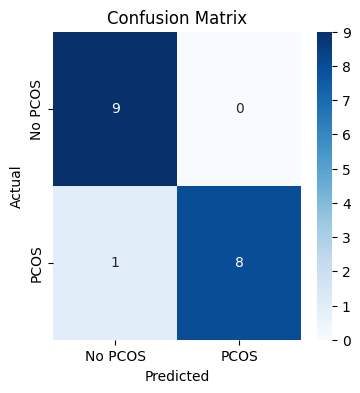

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No PCOS", "PCOS"],
            yticklabels=["No PCOS", "PCOS"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
import pickle

with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Saved new compatible pickle files")

✅ Saved new compatible pickle files


In [11]:
from google.colab import files
files.download("preprocessor.pkl")
files.download("model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
requirements = """streamlit
numpy==1.26.4
pandas==2.0.3
scikit-learn==1.4.2
xgboost==1.7.6
imbalanced-learn==0.12.0
shap
matplotlib
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import sklearn
import shap
import matplotlib.pyplot as plt

# ---------------- PAGE CONFIG ----------------
st.set_page_config(
    page_title="PCOS Early Detection",
    layout="wide",
)

st.title("🩺 PCOS Early Detection System")
st.caption("AI-based screening tool (Educational use only)")

# ---------------- VERSION CHECK ----------------
with st.expander("🔍 Environment Info"):
    st.write({
        "NumPy": np.__version__,
        "Pandas": pd.__version__,
        "Scikit-learn": sklearn.__version__,
    })

# ---------------- LOAD MODEL ----------------
try:
    with open("preprocessor.pkl", "rb") as f:
        preprocessor = pickle.load(f)

    with open("model.pkl", "rb") as f:
        model = pickle.load(f)

    st.success("✅ Model & preprocessor loaded successfully")

except Exception as e:
    st.error("❌ Failed to load model files")
    st.exception(e)
    st.stop()

# ---------------- FILE UPLOAD ----------------
st.header("📤 Upload Patient Dataset")

uploaded_file = st.file_uploader(
    "Upload CSV file with patient data",
    type=["csv"]
)

if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.subheader("📄 Uploaded Data Preview")
    st.dataframe(df.head())

    # ---------------- COLUMN CHECK ----------------
    expected_cols = list(preprocessor.feature_names_in_)
    uploaded_cols = df.columns.tolist()

    missing = set(expected_cols) - set(uploaded_cols)
    extra = set(uploaded_cols) - set(expected_cols)

    if missing:
        st.error("❌ Missing columns: " + ", ".join(missing))
        st.stop()

    if extra:
        df = df[expected_cols]

    # ---------------- TRANSFORM & PREDICT ----------------
    X_processed = preprocessor.transform(df)
    preds = model.predict(X_processed)
    probs = model.predict_proba(X_processed)[:, 1]

    results = df.copy()
    results["PCOS_Prediction"] = preds
    results["PCOS_Risk_Probability"] = probs

    st.subheader("📊 Prediction Results")
    st.dataframe(results)

    # ---------------- SHAP EXPLANATION ----------------
    st.subheader("🧠 Model Explanation (SHAP)")

    with st.spinner("Generating SHAP explanation..."):
        explainer = shap.Explainer(model)
        shap_values = explainer(X_processed[:50])

        fig, ax = plt.subplots()
        shap.plots.beeswarm(shap_values, show=False)
        st.pyplot(fig)

# ---------------- FOOTER ----------------
st.markdown("---")
st.caption("⚠️ This tool is for academic demonstration only, not a medical diagnosis.")

Writing app.py
